<h1> SERIE TEMPORALI

# Import

In [138]:
from google.colab import drive
drive.mount('/content/drive')

# path dataset
file_path = "/content/drive/MyDrive/Progetti data science/Progetto Python/Serie temporali/GlobalTemperatures.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
!pip install pmdarima
from pmdarima.arima import auto_arima

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler
import seaborn as sns
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tabulate import tabulate
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from math import sqrt
import statsmodels.api as sm 
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA 
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)
%matplotlib inline
from io import StringIO

# plot interattivi
import plotly.express as px


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# ETL

In [140]:
with open(file_path, 'r', encoding='utf8') as file:
  df = pd.read_csv(file, delimiter = ',')

df_feature = df.copy()
df

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3187,2015-08-01,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057
3188,2015-09-01,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058
3189,2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062
3190,2015-11-01,7.433,0.119,12.892,0.093,2.157,0.106,15.252,0.063


<h3> Eliminiamo le colonne non utili <h3>

In [141]:
colonne_da_mantenere = ['dt', 'LandAverageTemperature']
df.drop(df.columns.difference(colonne_da_mantenere), 1, inplace=True)
df = df.rename(columns={"dt":"Data"})
df

<ipython-input-141-a2bfed5c0f39>:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



,Data,LandAverageTemperature
0,1750-01-01,3.034
1,1750-02-01,3.083
2,1750-03-01,5.626
3,1750-04-01,8.490
4,1750-05-01,11.573
...,...,...
3187,2015-08-01,14.755
3188,2015-09-01,12.999
3189,2015-10-01,10.801
3190,2015-11-01,7.433


<h3> Trasformiamo la data in un datetime e la settiamo come indice <h3>

In [142]:
df["Data"] = pd.to_datetime(df["Data"])
df = df.set_index("Data")

df

,LandAverageTemperature
Data,
1750-01-01,3.034
1750-02-01,3.083
1750-03-01,5.626
1750-04-01,8.490
1750-05-01,11.573
...,...
2015-08-01,14.755
2015-09-01,12.999
2015-10-01,10.801


In [143]:
df.describe()

,LandAverageTemperature
count,3180.000000
mean,8.374731
std,4.381310
min,-2.080000
25%,4.312000
50%,8.610500
75%,12.548250
max,19.021000


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3192 entries, 1750-01-01 to 2015-12-01
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LandAverageTemperature  3180 non-null   float64
dtypes: float64(1)
memory usage: 49.9 KB


In [145]:
df.isnull().values.any()

True

In [146]:
df[df['LandAverageTemperature'].isna()]

,LandAverageTemperature
Data,
1750-11-01,NaN
1751-05-01,NaN
1751-07-01,NaN
1751-10-01,NaN
1751-11-01,NaN
1751-12-01,NaN
1752-02-01,NaN
1752-05-01,NaN
1752-06-01,NaN


In [147]:
df_copy = df
df = df[df.index>='1900-01-01']

df

,LandAverageTemperature
Data,
1900-01-01,1.461
1900-02-01,3.098
1900-03-01,5.492
1900-04-01,8.223
1900-05-01,11.385
...,...
2015-08-01,14.755
2015-09-01,12.999
2015-10-01,10.801


In [148]:
y = 'LandAverageTemperature'

# Analisi relativa ai singoli mesi

## Analisi del dataset

In [149]:
px.line(data_frame=df, x=df.index, y=y)

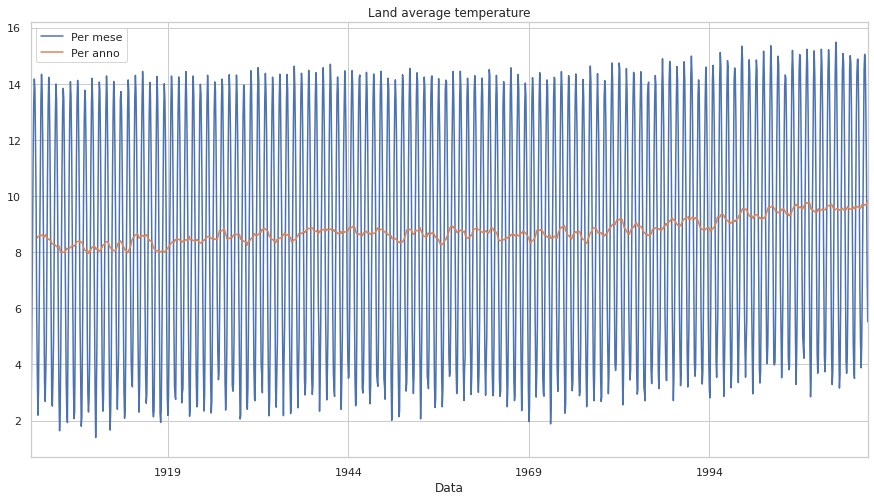

In [150]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,8))
plt.title("Land average temperature")
df[y].plot(label = 'Per mese')
df[y].rolling(window = 12).mean().plot(label='Per anno')
plt.legend()
plt.show()


### Analisi di trend, stagionalità e residui

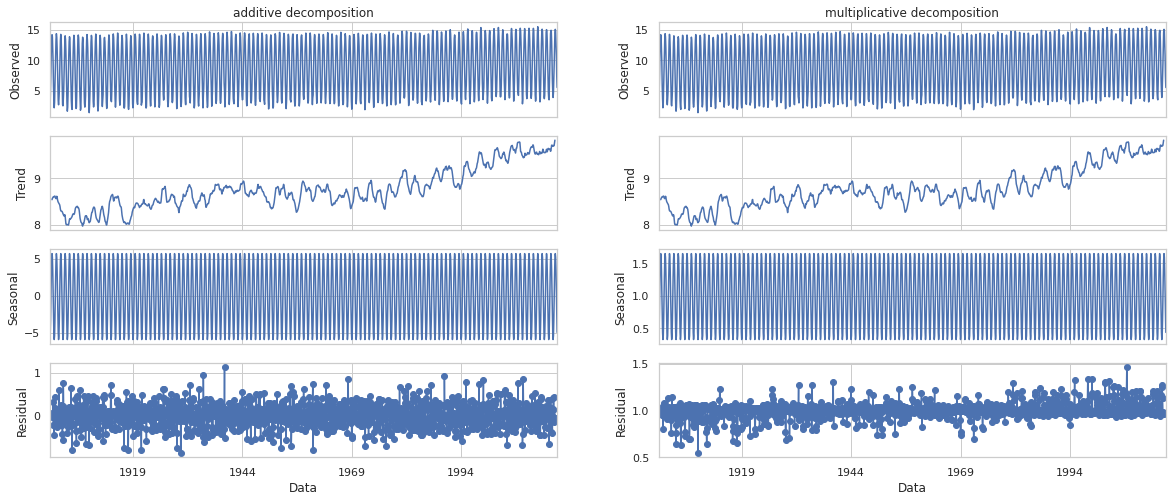

In [151]:
fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(20, 8))

for i,model in enumerate(['additive', 'multiplicative']):
    
    decomposition = sm.tsa.seasonal_decompose(df[y], period = 12, model=model) 
    decomposition.observed.plot(ax=axes[0,i], legend=False)
    axes[0,i].set_title(model + ' decomposition')
    axes[0,i].set_ylabel('Observed')
    
    decomposition.trend.plot(ax=axes[1,i], legend=False)
    axes[1,i].set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=axes[2,i], legend=False)
    axes[2,i].set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=axes[3,i], legend=False)
    axes[3,i].scatter(np.array(decomposition.resid.index), decomposition.resid)
    axes[3,i].set_ylabel('Residual')
plt.show()

<h3> Evidentemente è presente un trend, perciò sarà necessario differenziare.<h3>


<h3> Tagliamo la prima parte dei dati e li dividiamo in train e test <h3>

In [152]:
df_train = df[df.index<='2000/01/01']
df_test = df[df.index>'2000/01/01']

In [153]:
df_train

,LandAverageTemperature
Data,
1900-01-01,1.461
1900-02-01,3.098
1900-03-01,5.492
1900-04-01,8.223
1900-05-01,11.385
...,...
1999-09-01,12.723
1999-10-01,9.997
1999-11-01,6.592


In [154]:
df_test

,LandAverageTemperature
Data,
2000-02-01,4.184
2000-03-01,6.219
2000-04-01,9.552
2000-05-01,11.874
2000-06-01,14.060
...,...
2015-08-01,14.755
2015-09-01,12.999
2015-10-01,10.801


In [155]:
px.line(data_frame = df_train, x = df_train.index, y = y)

In [156]:
px.line(data_frame = df_test, x= df_test.index, y = y)

### Decomponiamo la serie temporale di training

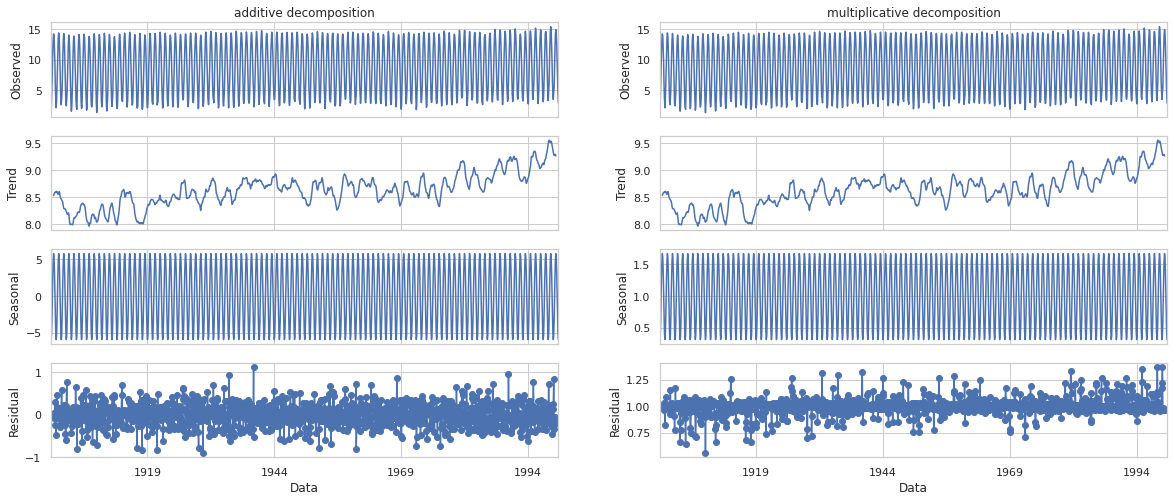

In [157]:
fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(20, 8))

for i,model in enumerate(['additive', 'multiplicative']):
    
    decomposition = sm.tsa.seasonal_decompose(df_train[y], period = 12, model=model) 
    decomposition.observed.plot(ax=axes[0,i], legend=False)
    axes[0,i].set_title(model + ' decomposition')
    axes[0,i].set_ylabel('Observed')
    
    decomposition.trend.plot(ax=axes[1,i], legend=False)
    axes[1,i].set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=axes[2,i], legend=False)
    axes[2,i].set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=axes[3,i], legend=False)
    axes[3,i].scatter(np.array(decomposition.resid.index), decomposition.resid)
    axes[3,i].set_ylabel('Residual')
plt.show()

In [158]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

In [159]:
test_stationarity(df_train[y])

Test Statistic            -1.599702
p-value                    0.483743
Lags                      23.000000
Observations            1177.000000
Critical Value (1%)       -3.435918
Critical Value (5%)       -2.863999
Critical Value (10%)      -2.568079
dtype: float64


In [160]:
df_diff = df_train.copy()

# first difference
df_diff[y] = df_train[y] - df_train[y].shift(1)

test_stationarity(df_diff[y].dropna(inplace=False))

Test Statistic         -1.563622e+01
p-value                 1.661739e-28
Lags                    2.200000e+01
Observations            1.177000e+03
Critical Value (1%)    -3.435918e+00
Critical Value (5%)    -2.863999e+00
Critical Value (10%)   -2.568079e+00
dtype: float64


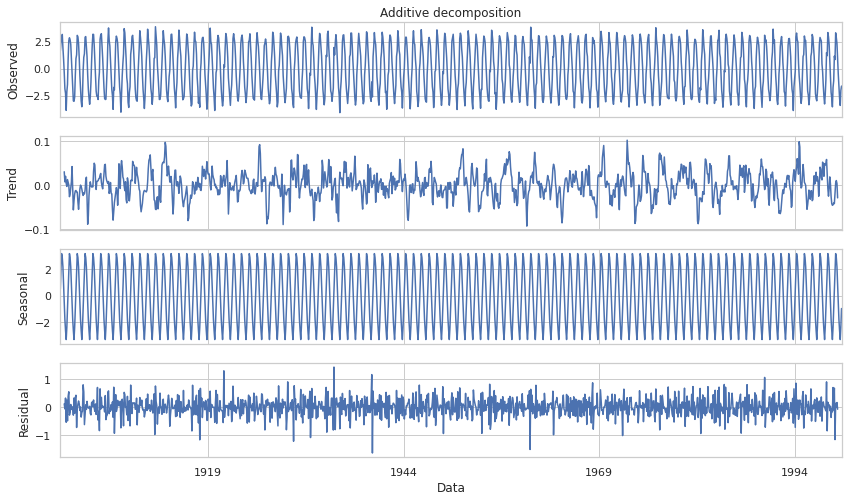

In [161]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(14, 8))    
decomposition = sm.tsa.seasonal_decompose(df_diff[y].dropna(), period = 12, model='additive') 
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_title('Additive decomposition')
axes[0].set_ylabel('Observed')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].plot(np.array(decomposition.resid.index), decomposition.resid)
axes[3].set_ylabel('Residual')
plt.show()

### Autocorrelazione e autocorrelazione parziale


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



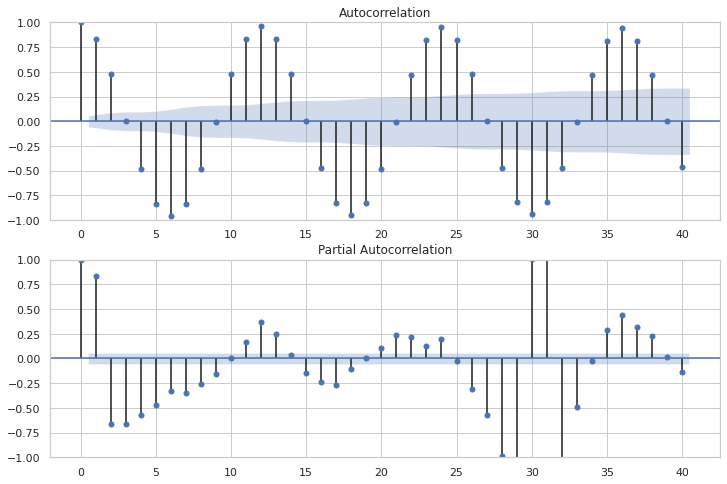

In [162]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_diff[y][1:], lags=40, ax=ax1)  
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_diff[y][1:], lags=40, ax=ax2)

## Creazione modello allenato sul dataset di train

### Creiamo un modello ARIMA esplorativo con d = 0 (la serie è già differenziata)

In [163]:
p, d, q = 1, 0, 2

arima_model = ARIMA(df_diff[y], order=(p,d,q)) 
trained_model = arima_model.fit()

print(trained_model.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                 SARIMAX Results                                  
Dep. Variable:     LandAverageTemperature   No. Observations:                 1201
Model:                     ARIMA(1, 0, 2)   Log Likelihood               -2106.197
Date:                    Thu, 19 Jan 2023   AIC                           4222.393
Time:                            12:42:30   BIC                           4247.848
Sample:                        01-01-1900   HQIC                          4231.981
                             - 01-01-2000                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.464      0.643      -0.002       0.003
ar.L1          0.8325      0.028     29.723      0.000       0.778       0.887
ma.L1         -0.248

<h3> Plot delle previsioni <h3>

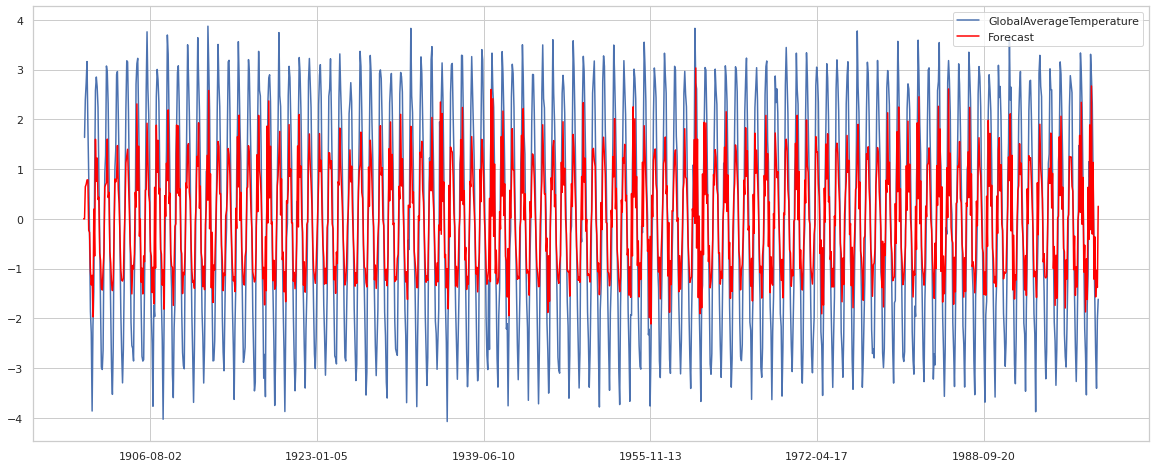

In [164]:
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(df_diff[y])
plt.plot(trained_model.fittedvalues, color='red')
ax.legend(['GlobalAverageTemperature', 'Forecast'])

ax.xaxis.set_major_locator(plt.MaxNLocator(8))

### Analisi dei residui

<h3> Plot del coefficiente di correlazione dei residui <h3> 

In [165]:
residuals = pd.DataFrame(trained_model.resid)

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



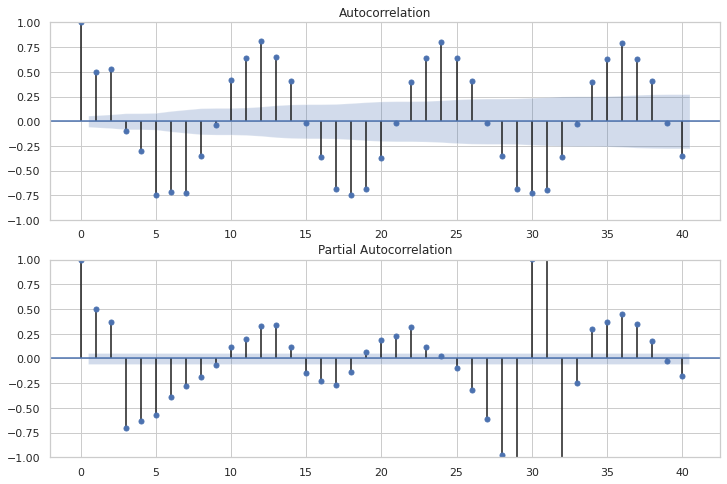

In [166]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals[1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals[1:], lags=40, ax=ax2)

Il modello non è adatto, poiché rimangono molte componenti al di fuori della regione di ammissibilità; ciò accade perchè non abbiamo considerato la stagionalità

<h3> Plot della distribuzione dei residui <h3>

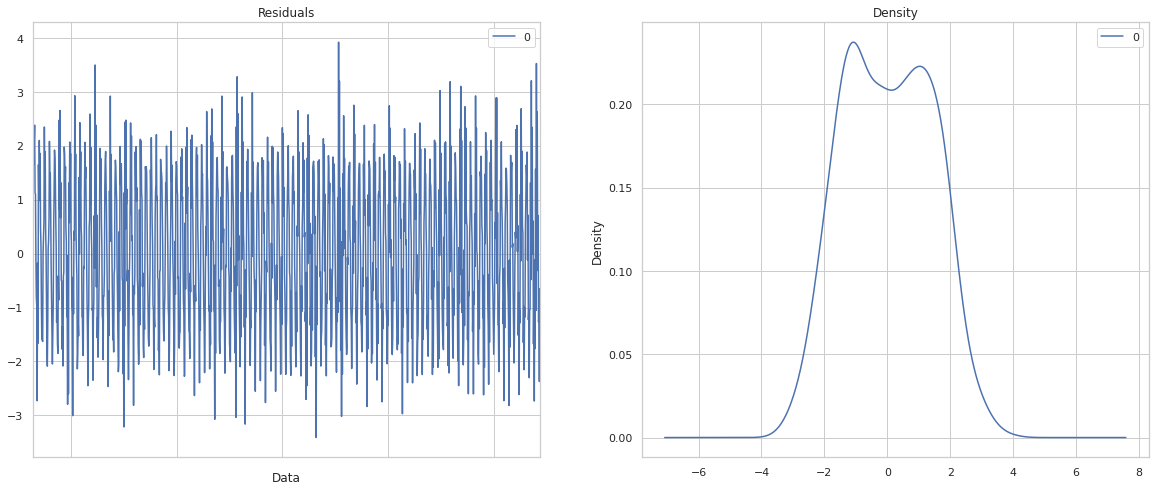

In [167]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
residuals.plot(title="Residuals", ax=ax[0])
ax[0].xaxis.set_major_locator(plt.MaxNLocator(5))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

I residui non sono piccoli e non seguono una gaussiana, quindi il modello non va bene; questo accade perchè non abbiamo considerato la stagionalità

## Cerchiamo il miglior modello ARIMA passandogli la serie originale non differenziata

<h3> Auto ARIMA per determinare il miglior modello

In [268]:
auto_model = auto_arima(df_train[y][1:], 
                      start_p=0, 
                      start_q=0,
                      max_p=2, 
                      max_q=2,
                      test='adf',
                      m=12,
                      trace=True,
                      seasonal=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True,
                      n_jobs=-1)

print(auto_model.summary())

/usr/local/lib/python3.8/dist-packages/pmdarima/arima/_validation.py:76: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=921.038, Time=7.02 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6849.898, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=7.99 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4367.595, Time=2.05 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=8836.417, Time=0.10 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=5478.643, Time=0.91 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=2.92 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=14.93 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=993.136, Time=11.75 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=3.03 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=8.01 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=19.88 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=646.564, Time=4.36 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=4042.991, Time=1.11 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=655.12

<h3> Alleniamo un modello nuovo con i parametri ottimi

In [273]:
p_best, d_best, q_best = 1, 1, 1
P_best, D_best, Q_best, m = 2, 1, 1, 12

arima_model = ARIMA(df_train[y], order = (p_best,d_best,q_best), seasonal_order = (P_best, D_best, Q_best, m)) 
trained_model_no_diff = arima_model.fit()
print(trained_model_no_diff.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                    SARIMAX Results                                     
Dep. Variable:           LandAverageTemperature   No. Observations:                 1201
Model:             ARIMA(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -263.911
Date:                          Thu, 19 Jan 2023   AIC                            539.821
Time:                                  14:40:25   BIC                            570.301
Sample:                              01-01-1900   HQIC                           551.309
                                   - 01-01-2000                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2877      0.031      9.232      0.000       0.227       0.349
ma.L1         -0.9072      0.016    -57.926      0.

### Analisi dei residui

<h3> Plot del coefficiente di correlazione dei residui <h3> 

In [274]:
residuals = pd.DataFrame(trained_model_no_diff.resid)

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



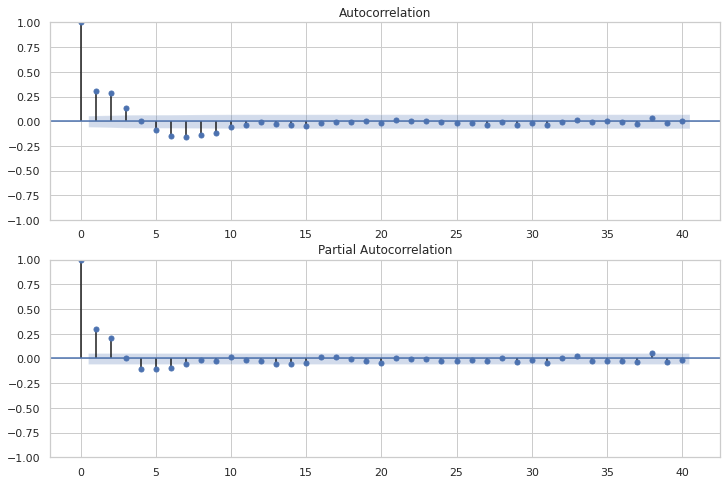

In [275]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals[1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals[1:], lags=40, ax=ax2)

Il modello riesce ad interpretare tutta la correlazione della serie, perché tutti i lag successivi al primo hanno valori molto bassi

<h3> Plot della distribuzione dei residui <h3>

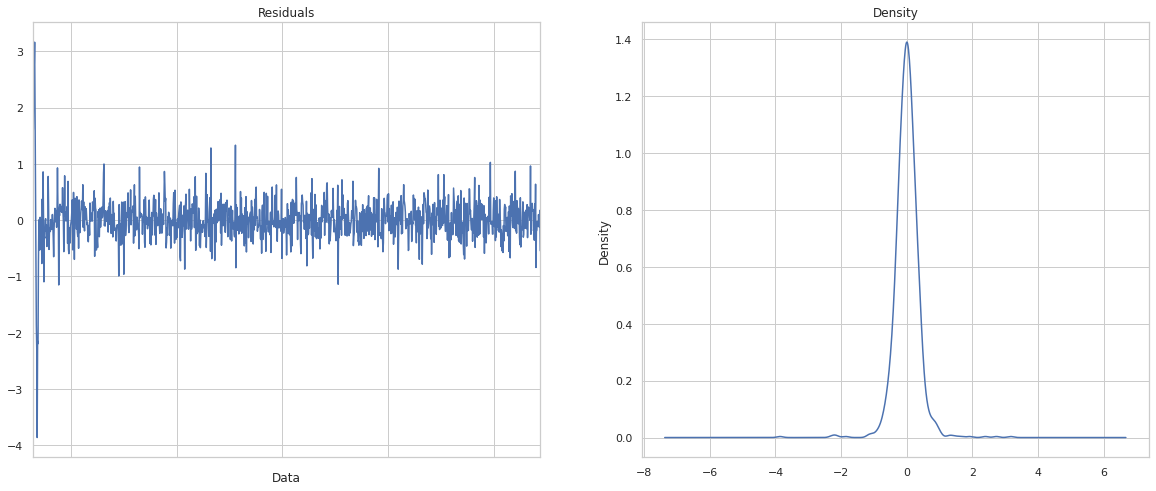

In [276]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
residuals.plot(title="Residuals", ax=ax[0])
ax[0].xaxis.set_major_locator(plt.MaxNLocator(5))
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[0].get_legend().remove()
ax[1].get_legend().remove()
plt.show()

I residui sono piccoli e seguono una gaussiana, quindi il modello va bene

### Visualizzazione sul Training Set

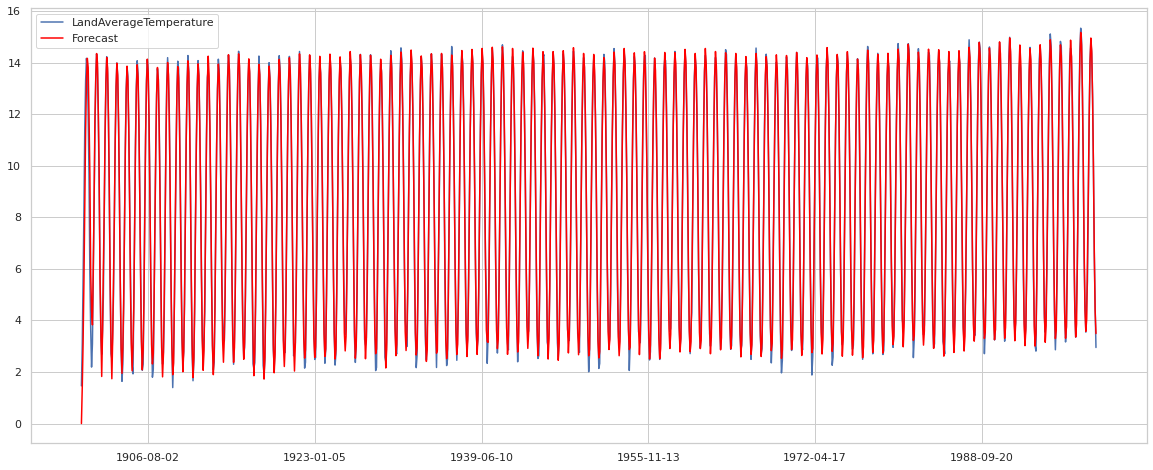

In [277]:
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(df_train[y])
plt.plot(trained_model_no_diff.fittedvalues, color='red')
ax.legend([y, 'Forecast'])
ax.xaxis.set_major_locator(plt.MaxNLocator(8))

<h3> Visualizziamo la previsione su un sottoinsieme dei dati di training <h3>

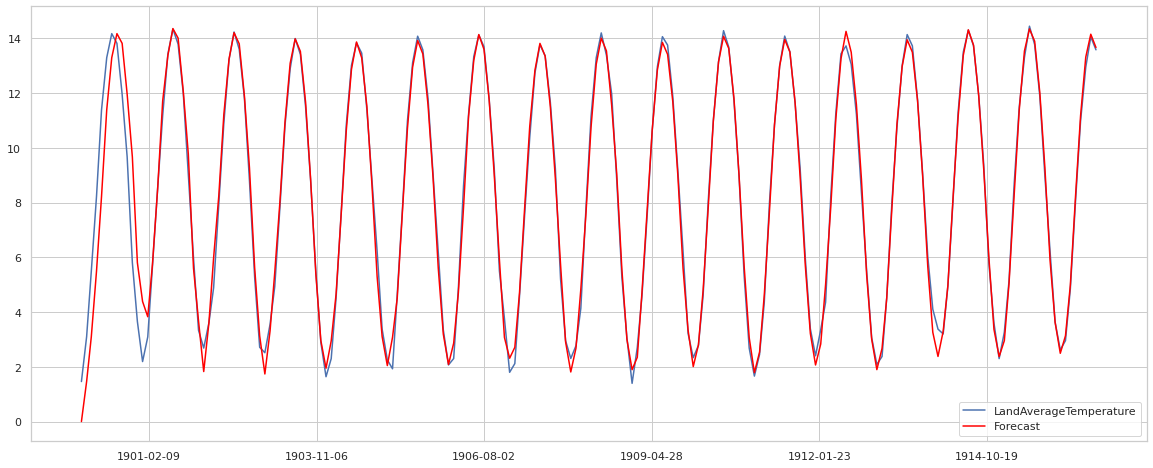

In [278]:
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(df_train[y][:200])
plt.plot(trained_model_no_diff.fittedvalues[:200], color='red')
ax.legend([y, 'Forecast'])
ax.xaxis.set_major_locator(plt.MaxNLocator(8))

### Previsioni su Test Set

<h3> Ultimo giorno del training set <h3>

In [284]:
df_train[y].tail(1)

Data
2000-01-01    2.95
Name: LandAverageTemperature, dtype: float64

<h3> Prevediamo i successivi n valori <h3>

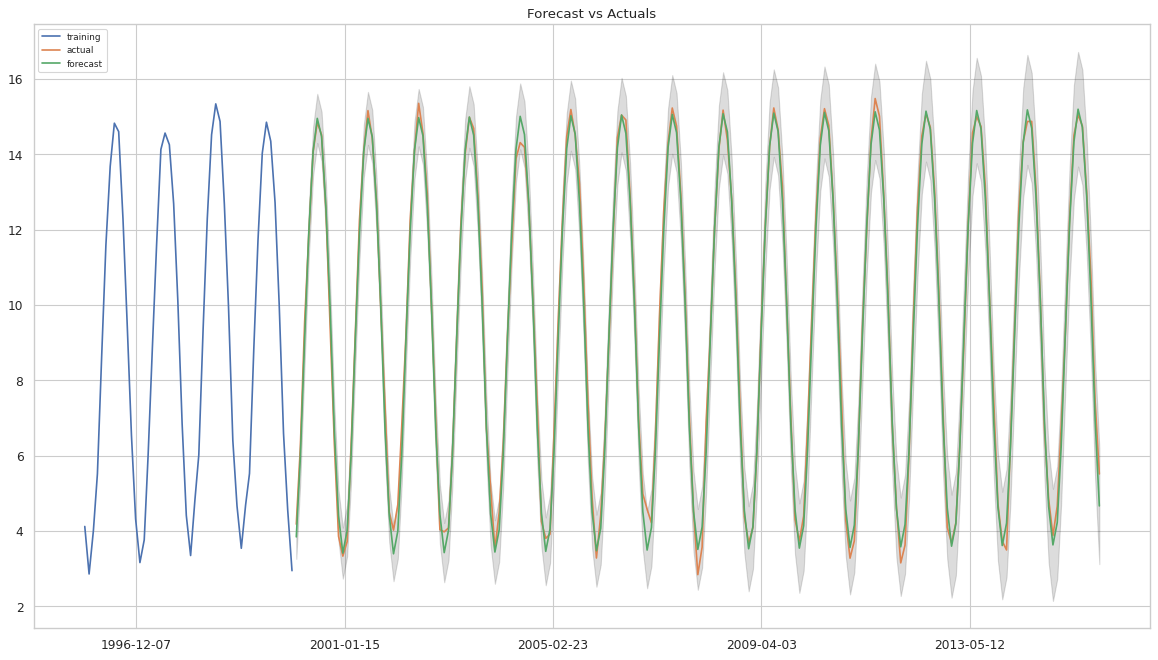

In [285]:
step = len(df_test)

# Forecast
fcast = trained_model_no_diff.get_forecast(steps = step, alpha=0.05).summary_frame()

fc_series = pd.DataFrame(fcast["mean"])
lower_series = pd.Series(fcast['mean_ci_upper'].values, index=fcast.index)
upper_series = pd.Series(fcast['mean_ci_lower'].values, index=fcast.index)

# Plot
fig, ax = plt.subplots(figsize=(18,10), dpi=80)
plt.plot(df_train[y][-50:], label='training')
plt.plot(df_test[y][:step], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))

plt.show()

In [286]:
mae = round(metrics.mean_absolute_error(df_test[y], fc_series), 4) 

mse = round(metrics.mean_squared_error(df_test[y], fc_series), 4) 

rmse = round(np.sqrt(mse), 4)

mad = round(metrics.median_absolute_error(df_test[y], fc_series), 4)

r2 = round(metrics.r2_score(df_test[y], fc_series), 4)

mape = metrics.mean_absolute_percentage_error(y_true = df_test[y], y_pred = fc_series)

mae, mse, rmse, mad, r2, mape

(0.2565, 0.1078, 0.3283, 0.2078, 0.9936, 0.038325922242483386)

In [288]:
df_forecast = pd.concat([fc_series.apply(lambda x: round(x, 1)), df_test[y][:step]], axis=1)
df_forecast.columns = ['Forecast', 'Actuals']

df_forecast

,Forecast,Actuals
2000-02-01,3.8,4.184
2000-03-01,5.9,6.219
2000-04-01,9.1,9.552
2000-05-01,11.9,11.874
2000-06-01,14.1,14.060
...,...,...
2015-08-01,14.7,14.755
2015-09-01,12.9,12.999
2015-10-01,10.2,10.801
2015-11-01,6.9,7.433


# Analisi relativa ai singoli anni

## Analisi del dataset

In [289]:
df = df_copy.resample('A-DEC').mean()

In [290]:
df = df[100:]

df

,LandAverageTemperature
Data,
1850-12-31,7.900667
1851-12-31,8.178583
1852-12-31,8.100167
1853-12-31,8.041833
1854-12-31,8.210500
...,...
2011-12-31,9.516000
2012-12-31,9.507333
2013-12-31,9.606500


In [291]:
px.line(data_frame=df, x=df.index, y=y)

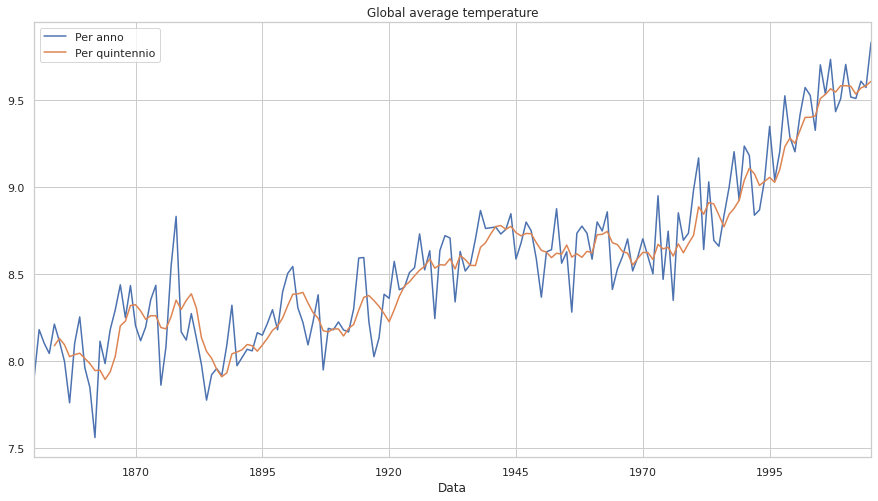

In [324]:
sns.set()
sns.set_style('whitegrid')
plt.figure(figsize=(15,8))
plt.title("Global average temperature")
df[y].plot(label = 'Per anno')
df[y].rolling(window = 5).mean().plot(label='Per quintennio')
plt.legend()
plt.show()
plt.figsize = (20, 20)

### Analisi di trend, stagionalità e residui

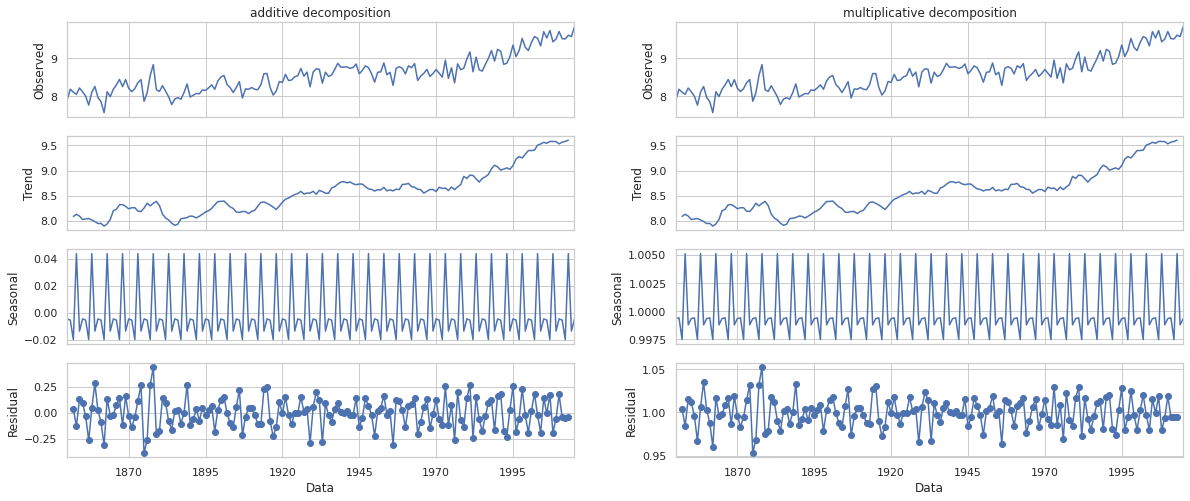

In [293]:
fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(20, 8))

for i,model in enumerate(['additive', 'multiplicative']):
    
    decomposition = sm.tsa.seasonal_decompose(df[y], period = 5, model=model) 
    decomposition.observed.plot(ax=axes[0,i], legend=False)
    axes[0,i].set_title(model + ' decomposition')
    axes[0,i].set_ylabel('Observed')
    
    decomposition.trend.plot(ax=axes[1,i], legend=False)
    axes[1,i].set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=axes[2,i], legend=False)
    axes[2,i].set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=axes[3,i], legend=False)
    axes[3,i].scatter(np.array(decomposition.resid.index), decomposition.resid)
    axes[3,i].set_ylabel('Residual')

plt.show()

<h3> Evidentemente è presente un trend, perciò sarà necessario differenziare.<h3>


<h3> Tagliamo la prima parte dei dati e li dividiamo in train e test <h3>

In [294]:
df_train = df[df.index <= '1950/01/01']
df_test = df[df.index > '1950/01/01']

In [295]:
df_train

,LandAverageTemperature
Data,
1850-12-31,7.900667
1851-12-31,8.178583
1852-12-31,8.100167
1853-12-31,8.041833
1854-12-31,8.210500
...,...
1945-12-31,8.584833
1946-12-31,8.676917
1947-12-31,8.797083


In [296]:
df_test

,LandAverageTemperature
Data,
1950-12-31,8.365250
1951-12-31,8.625667
1952-12-31,8.638250
1953-12-31,8.873750
1954-12-31,8.560667
...,...
2011-12-31,9.516000
2012-12-31,9.507333
2013-12-31,9.606500


In [297]:
df_copy.describe()

,LandAverageTemperature
count,3180.000000
mean,8.374731
std,4.381310
min,-2.080000
25%,4.312000
50%,8.610500
75%,12.548250
max,19.021000


In [298]:
px.line(data_frame = df_train, x = df_train.index, y = y)

In [299]:
px.line(data_frame = df_test, x = df_test.index, y = y)

### Decomponiamo la serie temporale di training

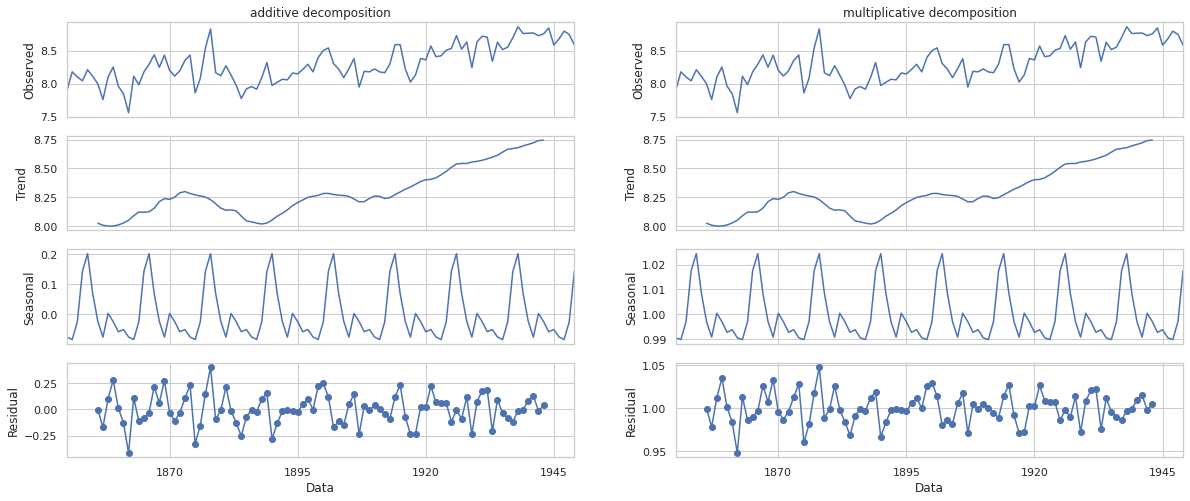

In [385]:
fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(20, 8))

for i,model in enumerate(['additive', 'multiplicative']):
    
    decomposition = sm.tsa.seasonal_decompose(df_train[y], period = 12, model=model) 
    decomposition.observed.plot(ax=axes[0,i], legend=False)
    axes[0,i].set_title(model + ' decomposition')
    axes[0,i].set_ylabel('Observed')
    
    decomposition.trend.plot(ax=axes[1,i], legend=False)
    axes[1,i].set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=axes[2,i], legend=False)
    axes[2,i].set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=axes[3,i], legend=False)
    axes[3,i].scatter(np.array(decomposition.resid.index), decomposition.resid)
    axes[3,i].set_ylabel('Residual')

plt.show()

In [301]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

In [302]:
test_stationarity(df_train[y])

Test Statistic          -1.492266
p-value                  0.537334
Lags                     3.000000
Observations            96.000000
Critical Value (1%)     -3.500379
Critical Value (5%)     -2.892152
Critical Value (10%)    -2.583100
dtype: float64


In [303]:
df_diff = df_train.copy()

# first difference
df_diff[y] = df_train[y] - df_train[y].shift(1)

test_stationarity(df_diff[y].dropna(inplace=False))

Test Statistic         -1.035939e+01
p-value                 2.418798e-18
Lags                    2.000000e+00
Observations            9.600000e+01
Critical Value (1%)    -3.500379e+00
Critical Value (5%)    -2.892152e+00
Critical Value (10%)   -2.583100e+00
dtype: float64


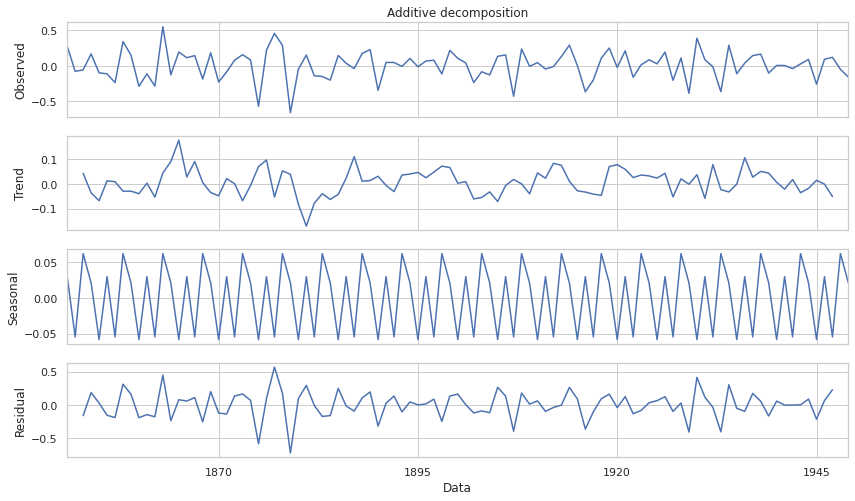

In [387]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(14, 8))    
decomposition = sm.tsa.seasonal_decompose(df_diff[y].dropna(), period = 5, model='additive') 
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_title('Additive decomposition')
axes[0].set_ylabel('Observed')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].plot(np.array(decomposition.resid.index), decomposition.resid)
axes[3].set_ylabel('Residual')
plt.show()

### Autocorrelazione e autocorrelazione parziale


/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



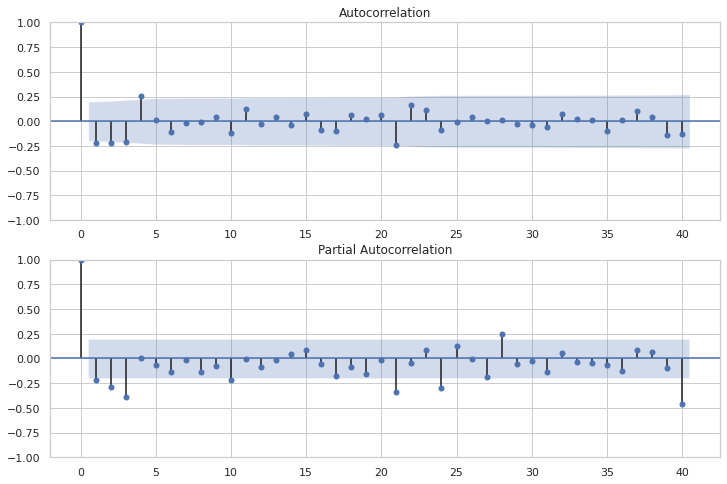

In [305]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_diff[y][1:], lags=40, ax=ax1)  
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_diff[y][1:], lags=40, ax=ax2)

## Creazione modello allenato sul dataset di train

### Creiamo un modello ARIMA esplorativo con d = 0 (la serie è già differenziata)

In [306]:
p, d, q = 1, 0, 2

arima_model = ARIMA(df_diff[y], order=(p,d,q)) 
trained_model = arima_model.fit()

print(trained_model.summary())

                                 SARIMAX Results                                  
Dep. Variable:     LandAverageTemperature   No. Observations:                  100
Model:                     ARIMA(1, 0, 2)   Log Likelihood                  29.114
Date:                    Thu, 19 Jan 2023   AIC                            -48.228
Time:                            14:57:51   BIC                            -35.202
Sample:                        12-31-1850   HQIC                           -42.956
                             - 12-31-1949                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0073      0.003      2.664      0.008       0.002       0.013
ar.L1          0.2455      0.254      0.966      0.334      -0.253       0.744
ma.L1         -0.727

<h3> Plot delle previsioni <h3>

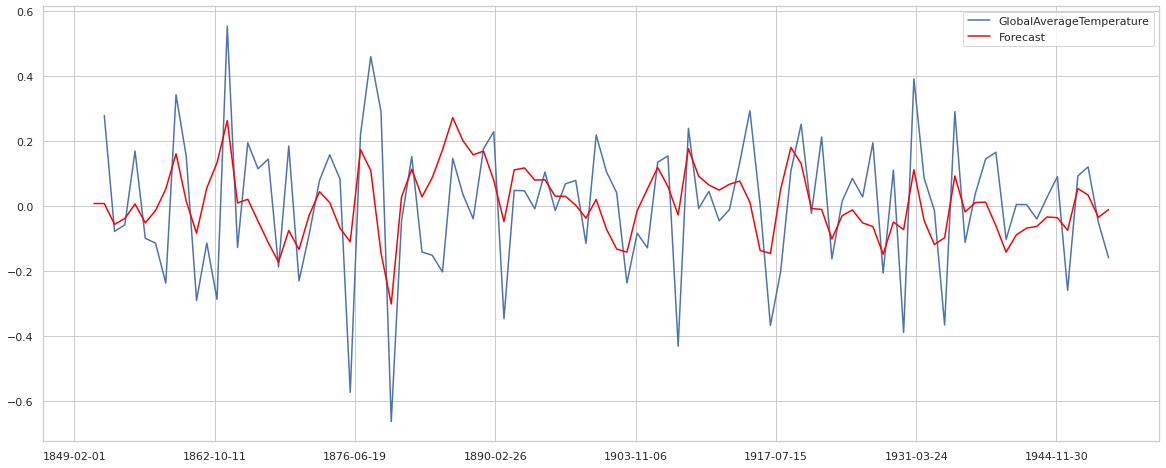

In [307]:
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(df_diff[y])
plt.plot(trained_model.fittedvalues, color='red')
ax.legend(['GlobalAverageTemperature', 'Forecast'])

ax.xaxis.set_major_locator(plt.MaxNLocator(8))

### Analisi dei residui

<h3> Plot del coefficiente di correlazione dei residui <h3> 

In [308]:
residuals = pd.DataFrame(trained_model.resid)

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



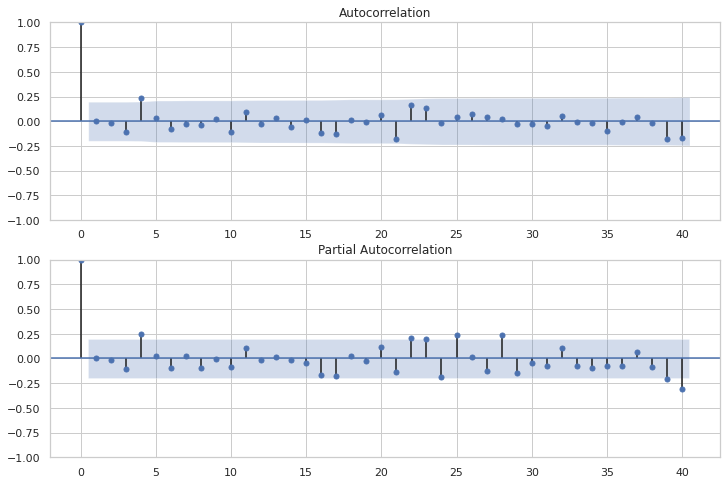

In [309]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals[1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals[1:], lags=40, ax=ax2)

Continuano ad esserci problemi relativi all'autocorrelazione parziale, questo accade perchè non abbiamo considerato la stagionalità

<h3> Plot della distribuzione dei residui <h3>

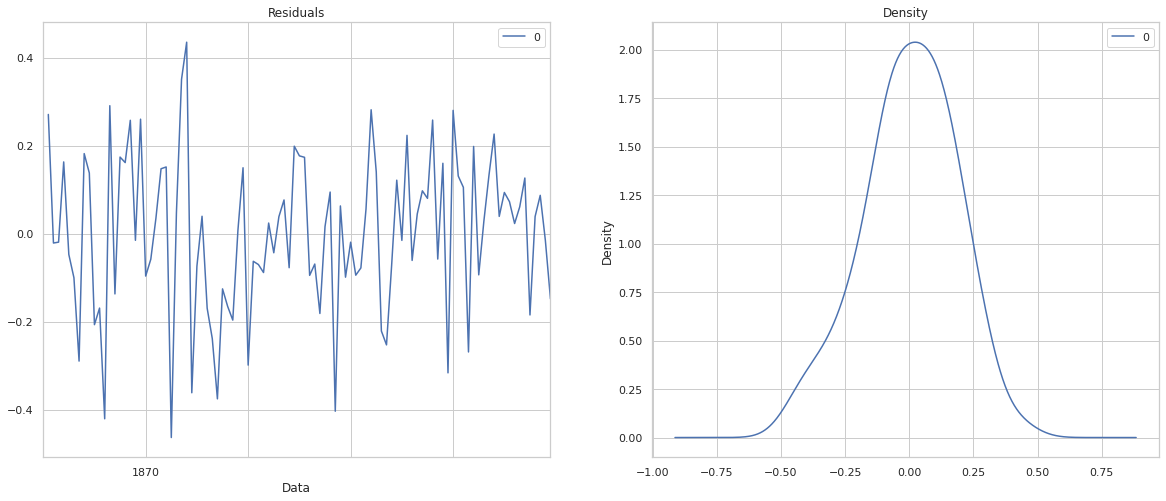

In [310]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
residuals.plot(title="Residuals", ax=ax[0])
ax[0].xaxis.set_major_locator(plt.MaxNLocator(5))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

I residui non sono piccoli e non seguono una gaussiana, quindi il modello non va bene; questo accade perchè non abbiamo considerato la stagionalità

## Cerchiamo il miglior modello ARIMA passandogli la serie originale non differenziata

<h3> Auto ARIMA per determinare il miglior modello

In [343]:
auto_model = auto_arima(df_train[y], 
                      start_p=0, 
                      start_d=0,
                      start_q=0,
                      max_p=5, 
                      max_q=5,
                      max_d=2,
                      start_P=0, 
                      start_Q=0,
                      start_D=0,
                      max_P=5, 
                      max_Q=5,
                      max_D=2,
                      test='adf',
                      m=12,
                      trace=True,
                      seasonal=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-26.602, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-27.476, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-39.366, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-28.491, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-41.090, Time=0.38 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-39.383, Time=0.70 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-38.465, Time=1.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-49.203, Time=0.15 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=-47.268, Time=0.33 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=-47.266, Time=0.38 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=-45.255, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-48.228, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=-49.352, Time=0.23 sec
 ARIMA(0,1,3)(1,0,0)[12] intercept   

<h3> Alleniamo un modello nuovo con i parametri ottimi

In [388]:
p_best, d_best, q_best = 3, 1, 0
P_best, D_best, Q_best = 2, 1, 0
m = 12

arima_model = ARIMA(df_train[y], order = (p_best,d_best,q_best), seasonal_order = (P_best, D_best, Q_best, m)) 
trained_model_no_diff = arima_model.fit()
print(trained_model_no_diff.summary())

                                    SARIMAX Results                                     
Dep. Variable:           LandAverageTemperature   No. Observations:                  100
Model:             ARIMA(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                  12.387
Date:                          Thu, 19 Jan 2023   AIC                            -12.775
Time:                                  15:55:47   BIC                              2.021
Sample:                              12-31-1850   HQIC                            -6.817
                                   - 12-31-1949                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5006      0.117     -4.293      0.000      -0.729      -0.272
ar.L2         -0.4884      0.098     -5.009      0.

### Analisi dei residui

<h3> Plot del coefficiente di correlazione dei residui <h3> 

In [375]:
residuals = pd.DataFrame(trained_model_no_diff.resid)

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



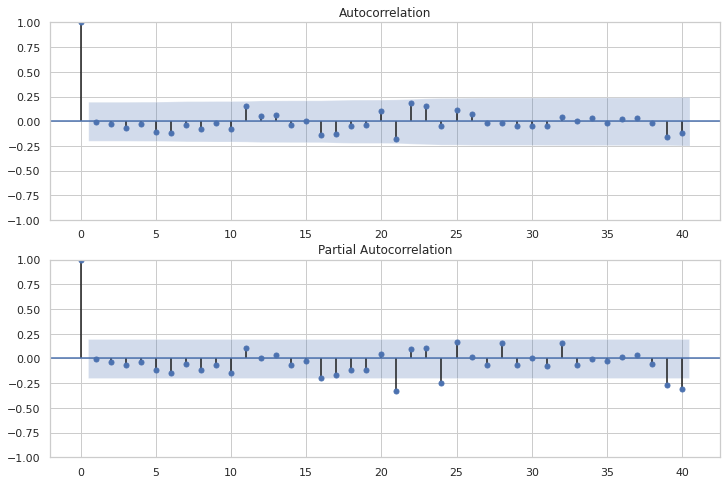

In [376]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals[1:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals[1:], lags=40, ax=ax2)

Il modello riesce ad interpretare tutta la correlazione della serie, perché tutti i lag successivi al primo hanno valori molto bassi

<h3> Plot della distribuzione dei residui <h3>

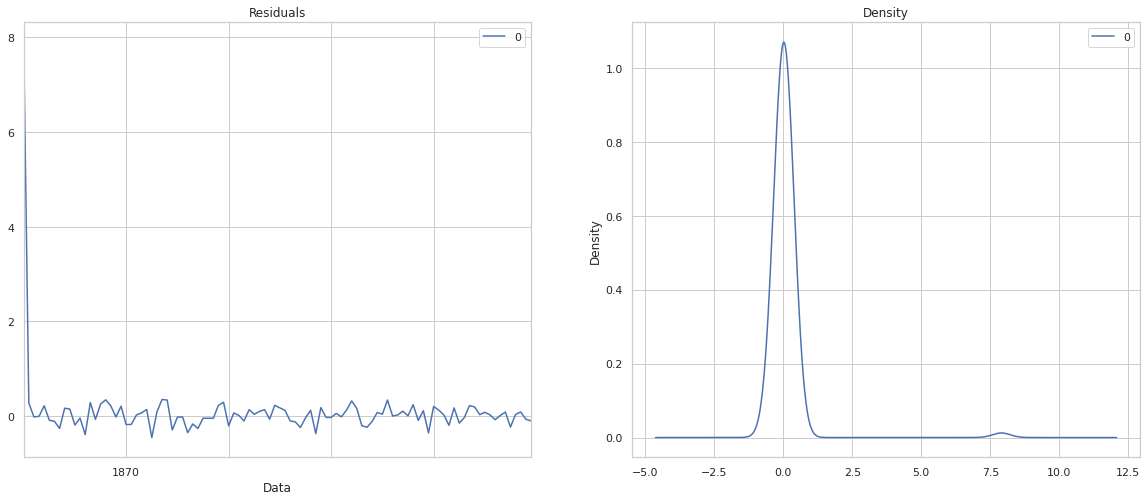

In [377]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
residuals.plot(title="Residuals", ax=ax[0])
ax[0].xaxis.set_major_locator(plt.MaxNLocator(5))
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

I residui sono piccoli e seguono una gaussiana, quindi il modello va bene

### Visualizzazione sul Training Set

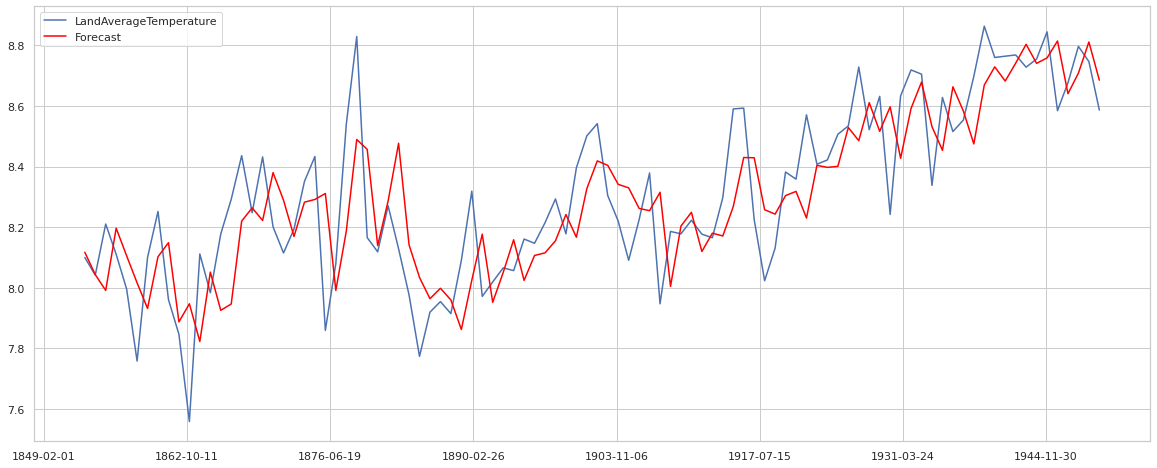

In [378]:
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(df_train[y][2:])
plt.plot(trained_model_no_diff.fittedvalues[2:], color='red')
ax.legend([y, 'Forecast'])
ax.xaxis.set_major_locator(plt.MaxNLocator(8))

<h3> Visualizziamo la previsione su un sottoinsieme dei dati di training <h3>

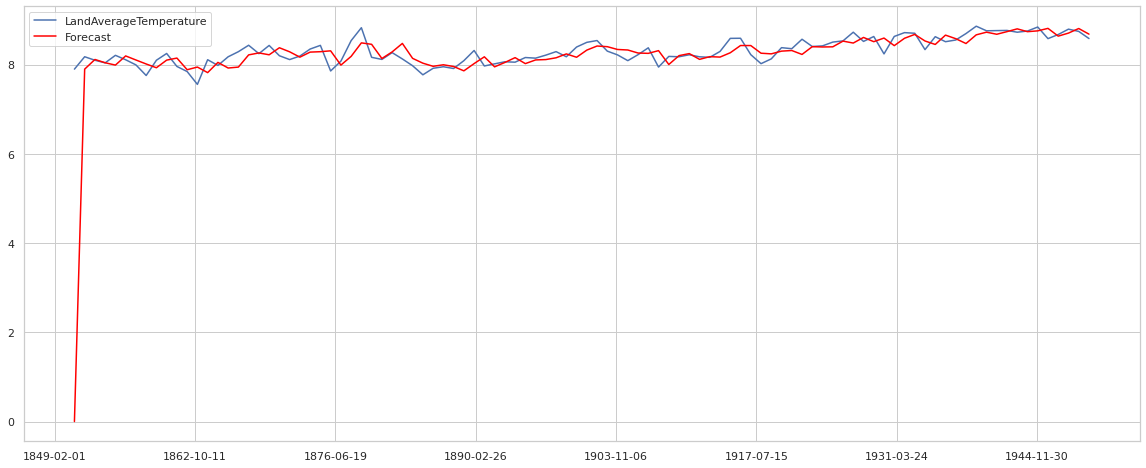

In [379]:
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(df_train[y][:200])
plt.plot(trained_model_no_diff.fittedvalues[:200], color='red')
ax.legend([y, 'Forecast'])
ax.xaxis.set_major_locator(plt.MaxNLocator(8))

### Previsioni su Test Set

<h3> Ultimo giorno del training set <h3>

In [380]:
df_train[y].tail(1)

Data
1949-12-31    8.58675
Freq: A-DEC, Name: LandAverageTemperature, dtype: float64

<h3> Prevediamo i successivi n valori <h3>

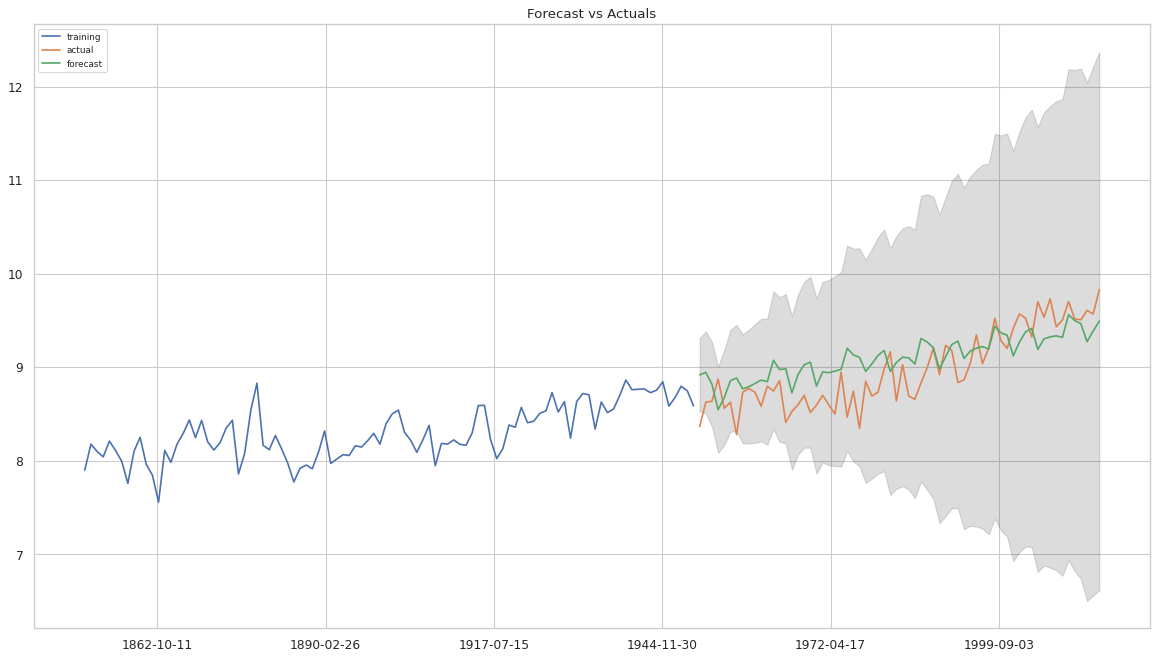

In [389]:
step = len(df_test)

# Forecast
fcast = trained_model_no_diff.get_forecast(steps = step, alpha=0.05).summary_frame()

fc_series = pd.DataFrame(fcast["mean"])
lower_series = pd.Series(fcast['mean_ci_upper'].values, index=fcast.index)
upper_series = pd.Series(fcast['mean_ci_lower'].values, index=fcast.index)

# Plot
fig, ax = plt.subplots(figsize=(18,10), dpi=80)
plt.plot(df_train[y][-100:], label='training')
plt.plot(df_test[y][:step], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))

plt.show()

In [391]:
mae = round(metrics.mean_absolute_error(df_test[y], fc_series), 4) 

mse = round(metrics.mean_squared_error(df_test[y], fc_series), 4) 

rmse = round(np.sqrt(mse), 4)

mad = round(metrics.median_absolute_error(df_test[y], fc_series), 4)

r2 = round(metrics.r2_score(df_test[y], fc_series), 4)

mape = metrics.mean_absolute_percentage_error(y_true = df_test[y], y_pred = fc_series)

mae, mse, rmse, mad, r2, mape

(0.2526, 0.0955, 0.309, 0.2188, 0.4195, 0.028591408809242002)

In [392]:
df_forecast = pd.concat([fc_series.apply(lambda x: round(x, 1)), df_test[y][:step]], axis=1)
df_forecast.columns = ['Forecast', 'Actuals']

df_forecast

,Forecast,Actuals
1950-12-31,8.9,8.365250
1951-12-31,8.9,8.625667
1952-12-31,8.8,8.638250
1953-12-31,8.5,8.873750
1954-12-31,8.7,8.560667
...,...,...
2011-12-31,9.5,9.516000
2012-12-31,9.5,9.507333
2013-12-31,9.3,9.606500
2014-12-31,9.4,9.570667
